In [21]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## 1. Нейронные сети с прямым распространением (feed forvard networks/FFN)

Это самая простая архитектура сетей. В них информация передаётся от входов к выходам. Это базовые сети, которые очень часто входят в состав других сетей.

Для иллюстрации работы НС с прямып распространением я использую базу данных <a href='https://www.niddk.nih.gov/'>Национального института диабета, заболеваний пищеварительной системы и болезней почек.</a> <img src="https://www.niddk.nih.gov/images/site-logo-full.svg", width=300>

Данные скачивал в <a href='https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/'>этом репозитории</a>.

Данные содержат различные измерения в популяции американских индейцев плеимени Пима, в популяции которых отмается высокая встречаемость диабета.

Это один из типичных наборов данных, на которых тестируют различные алгоритмы машинного обучения.

In [34]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data', header=0)
datafr=pd.DataFrame(data)
headers=['NP', 'PGC', 'DBP', 'TSFT', 'Insulin', 'BMass', 'DPF', 'Age', 'class']
datafr.columns=headers
datafr.head()

,NP,PGC,DBP,TSFT,Insulin,BMass,DPF,Age,class
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [27]:
datafr.shape

(767, 9)

Набор содержит данные 767 человек, здоровых и больных диабетом.
Каждый ряд - это пациент, каждый столбец- какой-либо показатель.

   1. NP (Number of times pregnant) - количество беременностей;
   2. PGC (Plasma glucose concentration) - концентрация глюкозы в плазме крови (через 2 часа после глюкозного теста);
   3. DBP (Diastolic blood pressure (mm Hg)) - диастолическое артериальное давление;
   4. TSFT (Triceps skin fold thickness (mm)) - толщина кожной складки;
   5. Insulin (2-Hour serum insulin (mu U/ml)) - уровень инсулина в сыворотке крови;
   6. BMass (Body mass index (weight in kg/(height in m)^2)) - индекс массы тела;
   7. DPF (Diabetes pedigree function) - Индекс встречаемости диабета в семье;
   8. Age (years) - возраст;
   9. Class variable (0 or 1) - переменная класса. Если 1, то у пациента диагностировали диабет. Если 0, то пациент никогда не страдал диабетом.

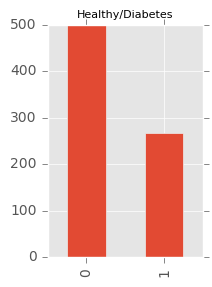

In [63]:
pd.value_counts(datafr['class']).plot(kind='bar', figsize=(2, 3))
plt.title('Healthy/Diabetes', fontsize=8)

В данном наборе 500 человек здоровые и 267 страдают диабетом

In [102]:
corellation=datafr.corr('pearson')
corellation[-1:]

,NP,PGC,DBP,TSFT,Insulin,BMass,DPF,Age,class
class,0.221087,0.465856,0.064882,0.073265,0.131984,0.292695,0.173245,0.236417,1.0


Видно, что линейная связь (<a/ href="http://medstatistic.ru/theory/pirson.html"> корелляция Пирсона</a>) у переменной класса (class) (той, которую нам нужно предсказать) больше 0.3 только в случае PGC-концентрации глюкозы в плазме(0.465856). Это значит, что зависимость между заболеваемостью диабетом и каким-либо ОДНИМ признаком слабая (меньше 0.3). Только в случае с показателем глюкозы в плазме крови она умеренная. 
Ни один из признаков В ОТДЕЛЬНОСТИ не даёт нам возможности судить о том, разовьётся диабет у пациента или нет.

Для того, чтобы предсказать развитие заболевания, нам необходимо каким-то образом обощить все эти признаки.

Собственно, для этого мы построим простую нейронную сеть с прямым распространением.

Схематично её можно изобразить вот так:
</a> <img src="ffn1.jpg", width=600>
Видно, что сеть имеет 8 входов, соответствующих количеству признаков, 2 скрытых слоя, имеющих 48 и 32 нейрона и один выход. Данные по модели перемещаются только вперёд от входного слоя к выходу. Каждый нейрон одного слоя связан со всеми нейронами последующего слоя синапсами. Во время обучения модели происходит коррекция синапсов и, таким образом, прохождение сигнала изменяется. Наша модель содержит ~2000 синапсов. Выход модели в данном случае будет один, так как мы выбираем только между двумя возможностями: "болен", либо "не болен". Выход в данном случае будет давать только одно число - вероятность болезни. Если вероятность больше 0.5, то сеть считает, что человек болен, если меньше 0.5, то скорее всего здоров. Можно сказать, что если выходной нейрон "возбуждается" сильно, модель считает, что человек болен.

Ниже я подготовил данные для модели, нормализовал их и случайным образом разделил на две выборки: 75% данных уйдёт на обучение модели (X_train и y_train), а 25% данных уйдёт на проверку, насколько хорошо модель справляется со своей задачей (X_test, y_test). То есть, 25%- тестовую выборку модель никогда не "видела" и поэтому, предсказание модели в отношении пациентов из этой выборки будут говорить об эффективности модели.

In [145]:
X_ds1=datafr.replace(0, np.nan)
X_ds2=datafr[[0,1,2,3,5,6,7]].fillna(datafr.median())
X_ds2['SerIns']=X_ds2[[4]].fillna(datafr.mean())

X=np.array(X_ds2[[0,1,2,3,4,5,6,7]])
X=MinMaxScaler().fit_transform(X)
y=np.array(datafr[[8]])
X_train, X_test, y_train, y_test=train_test_split(X_mstr,y, test_size=0.25, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((575L, 8L), (192L, 8L), (575L, 1L), (192L, 1L))

Теперь я создаю модель искусственной нейронной сети, как на схеме.

In [163]:
model = Sequential()
model.add(Dropout(0.1, input_shape=(8,)))
model.add(Dense(48, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, init='uniform', activation='sigmoid'))

sgd=SGD(lr=0.001, momentum=0.2, decay=1e-6, nesterov=1)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

filepath="weights_ind/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Теперь я загружаю данные в модель, указываю некоторые параметры а также, выборку, на основании которой будет производиться проверка способности нашей модели предсказывать.

In [167]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          verbose=2, 
          nb_epoch=5, 
          batch_size=10)

Train on 575 samples, validate on 192 samples
Epoch 1/5
0s - loss: 0.4962 - acc: 0.7565 - val_loss: 0.4469 - val_acc: 0.8021
Epoch 2/5
0s - loss: 0.5075 - acc: 0.7339 - val_loss: 0.4440 - val_acc: 0.8125
Epoch 3/5
0s - loss: 0.5002 - acc: 0.7409 - val_loss: 0.4401 - val_acc: 0.8021
Epoch 4/5
0s - loss: 0.5106 - acc: 0.7426 - val_loss: 0.4418 - val_acc: 0.7969
Epoch 5/5
0s - loss: 0.4899 - acc: 0.7583 - val_loss: 0.4413 - val_acc: 0.7969


</a> <img src="ffn1_output.png", width=800>
Обучение модели осуществляется несколько раз. 
Один цикл обучения называется эпохой. За одну эпоху модель просматривает данные 10 пациентов. Каждый раз, когда в модель поступают данные одного пациента, она делает предсказание. Предсказанное моделью число сравнивается с реальным. Если предсказанное чило ошибочно, ошибка вычисляется и модель корректируется. Затем постуают данные следующего пациента и.т.д.

Вывод вверху я представил с целью иллюстрации. Там всего 5 эпох и ~80% правильных ответов. Я тренировал модель в течение большего количества эпох и с разными параметрами. К 170 эпохе модель достигла точности 82%

In [170]:
model.load_weights('weights_ind/weights-improvement-172-0.82.hdf5')
scores=model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 82.29%


Предскажем, будет ли у пациентов диабет и выведем результат для первых 20:

In [189]:
predicted=model.predict_classes(X_test, verbose=0)

pr=pd.DataFrame(np.hstack((y_test, predicted)))
pr.columns=['true', 'predicted']
pr[:20]

,true,predicted
0,1,1
1,0,0
2,1,1
3,1,0
4,0,0
5,0,0
6,1,1
7,0,0
8,0,0
9,0,0


Видим, что многие ответы модели (столбец "predicted") совпадают с реальными ответами.

Итак, мы создали и протестировали модель для предсказания только двух классов. Можно сделать модель для большего числа классов или чисел.

Модели, подобные описанной мною широко применяются во многих отраслях, в т.ч. и медицине.

Например, <a/ href="https://pdfs.semanticscholar.org/7e1a/23188b00c719e656b7949a7c9a1ff2ab841e.pdf">в данной работе</a> рассматриваются FFN для диагностирования развития острого нефрита на основании различных симптомов. <a/ href="https://www.ncbi.nlm.nih.gov/pubmed?linkname=pubmed_pubmed_reviews&from_uid=8818370"> Есть работы и в психиатрии.</a>